# Training Data Acquisition and Labeling

In this notebook, we go through the dataset and create .csv labels based on their .midi pitch. After doing that, we feed PyTorch the necessary information about onsets and generate training data on-the-fly.

I am largely basing my work on the efforts of Thomas Holz, whose work with the E-GMD dataset has been invaluable to creating my own model. I will be using their master thesis' lists of filenames in the E-GMD dataset that are faulty and unfit for training. I will also adopt their instrument grouping method.

## Setup

In [23]:
%matplotlib inline

import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import pretty_midi
import numpy as np
import os
import csv

dataset_loc = "e-gmd-v1.0.0/"
drum_floor = 22
drum_ceil = 76

The `drum_floor` and `drum_ceiling` parameters are necessary as many MIDIs have pitches that play way outside of the traditional MIDI drum range (36 and up). That way we can make sure to cutoff any unnecessary data.

## What are MIDI ticks?

Note that the `time` value for events in MIDI files is measured in **delta time MIDI ticks**. 

A tick is the smallest unit of time in MIDIs, and their duration is defined by the `ticks_per_beat` parameter stored in the MIDI file. In our dataset, all files have a fixed `ticks_per_beat` value of `480`, which means every beat lasts 480 ticks. Now, traditionally, a song's beat duration or tempo is defined by BPM, beats per minute. In case of MIDIs however, the `tempo` is measured in microseconds per beat. For example, 100 BPM would equate to 600,000 μSPB. 

To convert $BPM$ to $\mu{SPB}$, we can use the following formula: 

$$ \mu{SPB} = \frac{60}{BPM} \cdot 10^6 $$

The formula for converting ticks to seconds would like something like this: 

$$ t_{sec} = \frac{t_{tick} \cdot \mu{SPB}}{TPB \cdot 10^6} $$

where:

* $t_{sec}$ is the absolute time in seconds
* $t_{tick}$ is the absolute time in ticks
* $TPB$ is the number of ticks per beat specified in the MIDI file
* $\mu SPB$ is the tempo of the MIDI file in microseconds per beat

For convenience, the `mido` package has built-in conversion functions like `bpm2tempo(bpm)`, `tempo2bpm(tempo)` and `tick2second(tick, ticks_per_beat, tempo)`. We will be using the `pretty_midi` package that converts all ticks to seconds for us.

## Getting MIDI onsets

The following function takes a MIDI filename as input and displays a piano-roll of drum instruments. This is just a helper function to visualize MIDIs in testing.

In [3]:
def plot_drum_track(midi_file, drum_program=0):
    # Load MIDI file and select drum track
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    drum_track = midi_data.instruments[0]
    drum_track.is_drum = False
    drum_track.program = drum_program
    unique_pitches = np.unique([x.pitch-drum_floor for x in drum_track.notes if x.pitch >= drum_floor])

    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(12, 4))
    plt.subplots_adjust(bottom=0.2)

    # Plot piano roll and labels for each drum note
    drum_roll = drum_track.get_piano_roll(fs=100)[drum_floor:drum_ceil]
    im = ax.imshow(drum_roll, aspect='auto', origin='lower', cmap='coolwarm')
    ax.set_yticks(unique_pitches)
    ax.set_yticklabels([pretty_midi.note_number_to_drum_name(x+drum_floor) for x in ax.get_yticks()])
    ax.set_ylabel('Drum')
    ax.set_xlabel('Time (10ms)')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)

    plt.show()

The `extract_drums` function iterates over each MIDI instrument in the parsed data, and if an instrument is found to be a drum instrument, the function returns that instrument. It also cuts out any pitches outside of the `drum_floor` - `drum_ceiling` range.

The `instrument_to_csv` takes that instrument and writes it to a .csv file, which is what we are going to be using to convert MIDIs to .csv.

In [24]:
drum_mapping={
          36: "kick",

          38: "snare",
          40: "snare_rimshot",
          37: "snare_xstick",

          48: "tom1",
          50: "tom1_rim",
          45: "tom2",
          47: "tom2_rim",
          43: "tom3",
          58: "tom3_rim",

          46: "hhopen_bow",
          26: "hhopen_edge",
          42: "hhclosed_bow",
          22: "hhclosed_edge",
          44: "hhpedal",
          
          49: "crash1_bow",
          55: "crash1_edge",
          57: "crash2_bow",
          52: "crash2_edge",
          51: "ride_bow",
          59: "ride_edge",
          53: "ride_bell",
          
          39: "clap",
          54: "tambourine",
          56: "cowbell"
}

In [25]:
def extract_drums(path):
    midi_data = pretty_midi.PrettyMIDI(path)
    for instr in midi_data.instruments:
        if instr.is_drum:
            # we make sure to cutoff any unnecessary frequencies
            instr.notes = [x for x in instr.notes if drum_floor <= x.pitch <= drum_ceil]
            return instr
    return None

def instrument_to_csv(instrument, csv_filename, length, threshold=0.02):
    with open(csv_filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['pitches', 'velocities', 'start_time', 'end_time'])
        
        notes = sorted(instrument.notes, key=lambda note: note.start)  # sort notes by start time
        notes = [note for note in notes if note.start < length]

        # group nearby notes together based on threshold
        groups = []
        current_group = [notes[0]]
        for i in range(1, len(notes)):
            if notes[i].start - current_group[0].start < threshold:
                current_group.append(notes[i])
            else:
                groups.append(current_group)
                current_group = [notes[i]]
        groups.append(current_group)
        
        # write each group to CSV
        for group in groups:
            pitches = " ".join([str(note.pitch) for note in group])
            velocities = " ".join([str(note.velocity) for note in group])
            start_time = group[0].start
            end_time = group[-1].end
            csvwriter.writerow([pitches, velocities, start_time, end_time])

def midi_to_csv(midi_path, csv_path, length):
    instrument_to_csv(extract_drums(midi_path), csv_path, length)

We can also write a helper function that uses FluidSynth to synthesize midis, which I will use to generate extra training data.

In [10]:
def synthesize_mid(midi_path):
    instr = extract_drums(midi_path)
    return Audio(instr.fluidsynth(44100, "JV_1080_Drums.sf2"), rate=44100)

## MIDI to CSV

Now, let us load the dataset to label every audio file's instance of a drum note.

In [26]:
df = pd.read_csv(dataset_loc+"e-gmd-v1.0.0.csv")
df

,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Acoustic Kit
1,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,JingleStacks (2nd Hi-Hat)
2,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Studio (Live Room)
3,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Classic Rock
4,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Jazz Funk
...,...,...,...,...,...,...,...,...,...,...,...,...
45532,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.844671,validation,drummer9/session1/12_rock_100_beat_4-4_56.midi,drummer9/session1/12_rock_100_beat_4-4_56.wav,Custom1
45533,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.850000,validation,drummer9/session1/12_rock_100_beat_4-4_57.midi,drummer9/session1/12_rock_100_beat_4-4_57.wav,Custom2
45534,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.850000,validation,drummer9/session1/12_rock_100_beat_4-4_58.midi,drummer9/session1/12_rock_100_beat_4-4_58.wav,Custom3
45535,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.744535,validation,drummer9/session1/12_rock_100_beat_4-4_6.midi,drummer9/session1/12_rock_100_beat_4-4_6.wav,Compact Lite (w/ Tambourine HH)


Let's create a new column in our dataframe to hold the .csv filename:

In [30]:
df['csv_filename'] = df['midi_filename'].str.replace(".midi", ".csv", regex=False)
df

C:\Users\pdimo\AppData\Local\Temp\ipykernel_19380\4140251854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['csv_filename'] = df['midi_filename'].str.replace(".midi", ".csv", regex=False)


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name,csv_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Acoustic Kit,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,JingleStacks (2nd Hi-Hat),drummer1/eval_session/1_funk-groove1_138_beat_...
2,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Studio (Live Room),drummer1/eval_session/1_funk-groove1_138_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Classic Rock,drummer1/eval_session/1_funk-groove1_138_beat_...
4,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Jazz Funk,drummer1/eval_session/1_funk-groove1_138_beat_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45532,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.844671,validation,drummer9/session1/12_rock_100_beat_4-4_56.midi,drummer9/session1/12_rock_100_beat_4-4_56.wav,Custom1,drummer9/session1/12_rock_100_beat_4-4_56.csv
45533,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.850000,validation,drummer9/session1/12_rock_100_beat_4-4_57.midi,drummer9/session1/12_rock_100_beat_4-4_57.wav,Custom2,drummer9/session1/12_rock_100_beat_4-4_57.csv
45534,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.850000,validation,drummer9/session1/12_rock_100_beat_4-4_58.midi,drummer9/session1/12_rock_100_beat_4-4_58.wav,Custom3,drummer9/session1/12_rock_100_beat_4-4_58.csv
45535,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.744535,validation,drummer9/session1/12_rock_100_beat_4-4_6.midi,drummer9/session1/12_rock_100_beat_4-4_6.wav,Compact Lite (w/ Tambourine HH),drummer9/session1/12_rock_100_beat_4-4_6.csv


With that, we can now generate .csv files for every MIDI file in the dataset.

In [31]:
df.apply(lambda x: midi_to_csv(dataset_loc+x['midi_filename'], dataset_loc+x['csv_filename'], x['duration']), axis=1)

# check if csv files are created
for csv_file in df['csv_filename']:
    if not os.path.exists(dataset_loc+csv_file):
        print(f"{csv_file} does not exist.")

Keep in mind that this database is not perfect and there are some misalignments between midi data and wav data. Luckily for us, Holz filtered out these misalignments in what he called the E-GMD-Clean dataset. We can simulate that by removing the elements he described:

In [27]:
empty_str = """1 drummer7/session3/25_hiphop_67_fill_4-4_23.wav 23 drummer7/session3/25_hiphop_67_fill_4-4_52.wav
2 drummer7/session3/25_hiphop_67_fill_4-4_21.wav 24 drummer7/session3/25_hiphop_67_fill_4-4_51.wav
3 drummer7/session3/25_hiphop_67_fill_4-4_25.wav 25 drummer7/session3/25_hiphop_67_fill_4-4_19.wav
4 drummer7/session3/25_hiphop_67_fill_4-4_36.wav 26 drummer7/session3/25_hiphop_67_fill_4-4_26.wav
5 drummer7/session3/25_hiphop_67_fill_4-4_18.wav 27 drummer7/session3/25_hiphop_67_fill_4-4_28.wav
6 drummer7/session3/25_hiphop_67_fill_4-4_1.wav 28 drummer7/session3/25_hiphop_67_fill_4-4_33.wav
7 drummer7/session3/25_hiphop_67_fill_4-4_8.wav 29 drummer7/session3/25_hiphop_67_fill_4-4_53.wav
8 drummer7/session3/25_hiphop_67_fill_4-4_54.wav 30 drummer7/session3/25_hiphop_67_fill_4-4_32.wav
9 drummer7/session3/25_hiphop_67_fill_4-4_16.wav 31 drummer7/session3/25_hiphop_67_fill_4-4_57.wav
10 drummer7/session3/25_hiphop_67_fill_4-4_42.wav 32 drummer7/session3/25_hiphop_67_fill_4-4_35.wav
11 drummer7/session3/25_hiphop_67_fill_4-4_5.wav 33 drummer7/session3/25_hiphop_67_fill_4-4_6.wav
12 drummer7/session3/25_hiphop_67_fill_4-4_43.wav 34 drummer7/session3/25_hiphop_67_fill_4-4_10.wav
13 drummer7/session3/25_hiphop_67_fill_4-4_12.wav 35 drummer7/session3/25_hiphop_67_fill_4-4_41.wav
14 drummer7/session3/25_hiphop_67_fill_4-4_24.wav 36 drummer7/session3/25_hiphop_67_fill_4-4_14.wav
15 drummer7/session3/25_hiphop_67_fill_4-4_56.wav 37 drummer7/session3/25_hiphop_67_fill_4-4_3.wav
16 drummer7/session3/25_hiphop_67_fill_4-4_11.wav 38 drummer7/session3/25_hiphop_67_fill_4-4_17.wav
17 drummer7/session3/25_hiphop_67_fill_4-4_55.wav 39 drummer7/session3/25_hiphop_67_fill_4-4_44.wav
18 drummer7/session3/25_hiphop_67_fill_4-4_34.wav 40 drummer7/session3/25_hiphop_67_fill_4-4_37.wav
19 drummer7/session3/25_hiphop_67_fill_4-4_31.wav 41 drummer7/session3/25_hiphop_67_fill_4-4_4.wav
20 drummer7/session3/25_hiphop_67_fill_4-4_13.wav 42 drummer7/session3/25_hiphop_67_fill_4-4_2.wav
21 drummer7/session3/25_hiphop_67_fill_4-4_15.wav 43 drummer7/session3/25_hiphop_67_fill_4-4_58.wav
22 drummer7/session3/25_hiphop_67_fill_4-4_22.wav""".split()

delayedonset_str = """1 drummer7/session3/146_soul_105_fill_4-4_52.midi 69 drummer7/session3/156_soul_98_fill_4-4_33.midi
2 drummer7/session3/63_funk_112_fill_4-4_10.midi 70 drummer3/session2/2_rock_100_beat_4-4_19.midi
3 drummer3/session2/2_rock_100_beat_4-4_41.midi 71 drummer7/session3/149_soul_105_fill_4-4_11.midi
4 drummer7/session2/81_country_78_fill_4-4_10.midi 72 drummer7/session3/146_soul_105_fill_4-4_55.midi
5 drummer1/session1/5_jazz-funk_116_beat_4-4_52.midi 73 drummer7/session3/156_soul_98_fill_4-4_15.midi
6 drummer1/session1/5_jazz-funk_116_beat_4-4_18.midi 74 drummer7/session2/81_country_78_fill_4-4_8.midi
7 drummer7/session3/109_rock_95_beat_4-4_43.midi 75 drummer1/session1/5_jazz-funk_116_beat_4-4_8.midi
8 drummer7/session3/25_hiphop_67_fill_4-4_28.midi 76 drummer7/session3/25_hiphop_67_fill_4-4_19.midi
9 drummer3/session2/2_rock_100_beat_4-4_2.midi 77 drummer7/session2/81_country_78_fill_4-4_51.midi
10 drummer3/session1/9_rock_105_beat_4-4_14.midi 78 drummer7/session3/149_soul_105_fill_4-4_5.midi
11 drummer7/session3/109_rock_95_beat_4-4_1.midi 79 drummer7/session3/109_rock_95_beat_4-4_33.midi
12 drummer7/session2/81_country_78_fill_4-4_26.midi 80 drummer7/session1/15_jazz_112_beat_4-4_3.midi
13 drummer7/session3/109_rock_95_beat_4-4_6.midi 81 drummer7/session3/156_soul_98_fill_4-4_58.midi
14 drummer7/session3/156_soul_98_fill_4-4_2.midi 82 drummer7/session3/63_funk_112_fill_4-4_17.midi
15 drummer3/session1/9_rock_105_beat_4-4_55.midi 83 drummer7/session3/63_funk_112_fill_4-4_33.midi
16 drummer3/session1/9_rock_105_beat_4-4_35.midi 84 drummer3/session1/9_rock_105_beat_4-4_24.midi
17 drummer3/session1/9_rock_105_beat_4-4_22.midi 85 drummer1/session1/5_jazz-funk_116_beat_4-4_56.midi
18 drummer7/session1/15_jazz_112_beat_4-4_25.midi 86 drummer10/session1/8_jazz-swing_215_beat_4-4_28.midi
19 drummer7/session1/15_jazz_112_beat_4-4_24.midi 87 drummer7/session3/149_soul_105_fill_4-4_33.midi
20 drummer7/session3/25_hiphop_67_fill_4-4_25.midi 88 drummer3/session2/2_rock_100_beat_4-4_12.midi
21 drummer7/session3/109_rock_95_beat_4-4_31.midi 89 drummer7/session3/25_hiphop_67_fill_4-4_21.midi
22 drummer7/session2/81_country_78_fill_4-4_43.midi 90 drummer3/session2/2_rock_100_beat_4-4_10.midi
23 drummer7/session3/25_hiphop_67_fill_4-4_16.midi 91 drummer7/session3/149_soul_105_fill_4-4_42.midi
24 drummer1/session1/5_jazz-funk_116_beat_4-4_13.midi 92 drummer7/session2/81_country_78_fill_4-4_31.midi
25 drummer7/session3/156_soul_98_fill_4-4_5.midi 93 drummer7/session2/81_country_78_fill_4-4_33.midi
26 drummer7/session1/15_jazz_112_beat_4-4_19.midi 94 drummer7/session3/149_soul_105_fill_4-4_23.midi
27 drummer3/session1/9_rock_105_beat_4-4_53.midi 95 drummer3/session2/2_rock_100_beat_4-4_33.midi
28 drummer3/session1/9_rock_105_beat_4-4_2.midi 96 drummer7/session3/63_funk_112_fill_4-4_37.midi
29 drummer7/session3/149_soul_105_fill_4-4_21.midi 97 drummer10/session1/8_jazz-swing_215_beat_4-4_42.midi
30 drummer3/session1/9_rock_105_beat_4-4_58.midi 98 drummer1/session1/5_jazz-funk_116_beat_4-4_51.midi
31 drummer7/session3/25_hiphop_67_fill_4-4_8.midi 99 drummer7/session3/63_funk_112_fill_4-4_21.midi
32 drummer7/session3/149_soul_105_fill_4-4_16.midi 100 drummer3/session1/9_rock_105_beat_4-4_43.midi
33 drummer7/session3/156_soul_98_fill_4-4_44.midi 101 drummer7/session3/149_soul_105_fill_4-4_35.midi
34 drummer7/session3/109_rock_95_beat_4-4_21.midi 102 drummer3/session1/9_rock_105_beat_4-4_33.midi
35 drummer3/session1/9_rock_105_beat_4-4_34.midi 103 drummer7/session3/156_soul_98_fill_4-4_35.midi
36 drummer7/session3/109_rock_95_beat_4-4_15.midi 104 drummer7/session1/15_jazz_112_beat_4-4_42.midi
37 drummer7/session2/81_country_78_fill_4-4_15.midi 105 drummer7/session3/63_funk_112_fill_4-4_24.midi
38 drummer3/session1/9_rock_105_beat_4-4_54.midi 106 drummer3/session1/9_rock_105_beat_4-4_44.midi
39 drummer10/session1/8_jazz-swing_215_beat_4-4_10.midi 107 drummer7/session3/25_hiphop_67_fill_4-4_5.midi
40 drummer7/session3/149_soul_105_fill_4-4_18.midi 108 drummer7/session3/146_soul_105_fill_4-4_58.midi
41 drummer1/session1/5_jazz-funk_116_beat_4-4_34.midi 109 drummer7/session2/81_country_78_fill_4-4_53.midi
42 drummer7/session3/25_hiphop_67_fill_4-4_56.midi 110 drummer7/session3/25_hiphop_67_fill_4-4_23.midi
43 drummer7/session3/109_rock_95_beat_4-4_32.midi 111 drummer1/session3/8_rock_135_beat_4-4_33.midi
44 drummer7/session3/149_soul_105_fill_4-4_52.midi 112 drummer7/session3/25_hiphop_67_fill_4-4_26.midi
45 drummer7/session3/25_hiphop_67_fill_4-4_43.midi 113 drummer7/session3/109_rock_95_beat_4-4_58.midi
46 drummer7/session3/146_soul_105_fill_4-4_11.midi 114 drummer7/session3/25_hiphop_67_fill_4-4_36.midi
47 drummer7/session3/146_soul_105_fill_4-4_16.midi 115 drummer1/session1/5_jazz-funk_116_beat_4-4_19.midi
48 drummer7/session1/15_jazz_112_beat_4-4_16.midi 116 drummer1/session1/5_jazz-funk_116_beat_4-4_12.midi
49 drummer7/session1/15_jazz_112_beat_4-4_51.midi 117 drummer7/session1/15_jazz_112_beat_4-4_52.midi
50 drummer7/session2/81_country_78_fill_4-4_1.midi 118 drummer7/session3/149_soul_105_fill_4-4_14.midi
51 drummer7/session2/81_country_78_fill_4-4_12.midi 119 drummer10/session1/8_jazz-swing_215_beat_4-4_23.midi
52 drummer3/session1/9_rock_105_beat_4-4_42.midi 120 drummer1/session1/5_jazz-funk_116_beat_4-4_15.midi
53 drummer7/session2/81_country_78_fill_4-4_25.midi 121 drummer7/session3/63_funk_112_fill_4-4_57.midi
54 drummer7/session3/149_soul_105_fill_4-4_28.midi 122 drummer7/session3/25_hiphop_67_fill_4-4_22.midi
55 drummer7/session3/56_funk_112_fill_4-4_19.midi 123 drummer3/session1/9_rock_105_beat_4-4_51.midi
56 drummer10/session1/8_jazz-swing_215_beat_4-4_2.midi 124 drummer7/session2/81_country_78_fill_4-4_56.midi
57 drummer7/session3/149_soul_105_fill_4-4_37.midi 125 drummer1/session1/5_jazz-funk_116_beat_4-4_25.midi
58 drummer7/session3/149_soul_105_fill_4-4_36.midi 126 drummer7/session3/156_soul_98_fill_4-4_41.midi
59 drummer7/session3/156_soul_98_fill_4-4_34.midi 127 drummer7/session3/149_soul_105_fill_4-4_2.midi
60 drummer7/session3/25_hiphop_67_fill_4-4_42.midi 128 drummer7/session1/15_jazz_112_beat_4-4_41.midi
61 drummer3/session2/2_rock_100_beat_4-4_56.midi 129 drummer3/session1/9_rock_105_beat_4-4_5.midi
62 drummer7/session3/63_funk_112_fill_4-4_28.midi 130 drummer3/session1/9_rock_105_beat_4-4_57.midi
63 drummer1/session1/5_jazz-funk_116_beat_4-4_10.midi 131 drummer3/session1/9_rock_105_beat_4-4_18.midi
64 drummer1/session1/5_jazz-funk_116_beat_4-4_26.midi 132 drummer3/session1/9_rock_105_beat_4-4_28.midi
65 drummer7/session3/109_rock_95_beat_4-4_57.midi 133 drummer7/session1/15_jazz_112_beat_4-4_35.midi
66 drummer7/session2/81_country_78_fill_4-4_17.midi 134 drummer7/session3/109_rock_95_beat_4-4_24.midi
67 drummer3/session1/9_rock_105_beat_4-4_8.midi 135 drummer7/session3/63_funk_112_fill_4-4_13.midi
68 drummer7/session1/15_jazz_112_beat_4-4_34.midi 136 drummer7/session2/81_country_78_fill_4-4_5.midi
137 drummer7/session1/15_jazz_112_beat_4-4_55.midi 210 drummer7/session3/25_hiphop_67_fill_4-4_33.midi
138 drummer7/session3/149_soul_105_fill_4-4_34.midi 211 drummer7/session2/81_country_78_fill_4-4_32.midi
139 drummer7/session3/156_soul_98_fill_4-4_16.midi 212 drummer7/session3/63_funk_112_fill_4-4_41.midi
140 drummer3/session2/2_rock_100_beat_4-4_15.midi 213 drummer7/session2/81_country_78_fill_4-4_44.midi
141 drummer7/session3/109_rock_95_beat_4-4_8.midi 214 drummer7/session2/81_country_78_fill_4-4_4.midi
142 drummer3/session2/2_rock_100_beat_4-4_25.midi 215 drummer3/session2/2_rock_100_beat_4-4_42.midi
143 drummer7/session3/63_funk_112_fill_4-4_35.midi 216 drummer7/session3/146_soul_105_fill_4-4_37.midi
144 drummer7/session2/81_country_78_fill_4-4_13.midi 217 drummer7/session3/63_funk_112_fill_4-4_15.midi
145 drummer7/session3/146_soul_105_fill_4-4_4.midi 218 drummer7/session3/156_soul_98_fill_4-4_10.midi
146 drummer7/session3/146_soul_105_fill_4-4_44.midi 219 drummer7/session3/63_funk_112_fill_4-4_16.midi
147 drummer7/session3/109_rock_95_beat_4-4_22.midi 220 drummer7/session3/146_soul_105_fill_4-4_32.midi
148 drummer3/session2/2_rock_100_beat_4-4_1.midi 221 drummer7/session1/15_jazz_112_beat_4-4_31.midi
149 drummer1/session1/5_jazz-funk_116_beat_4-4_6.midi 222 drummer3/session1/9_rock_105_beat_4-4_6.midi
150 drummer3/session1/9_rock_105_beat_4-4_56.midi 223 drummer7/session1/15_jazz_112_beat_4-4_1.midi
151 drummer7/session1/15_jazz_112_beat_4-4_18.midi 224 drummer3/session1/9_rock_105_beat_4-4_10.midi
152 drummer3/session2/2_rock_100_beat_4-4_8.midi 225 drummer7/session3/63_funk_112_fill_4-4_18.midi
153 drummer3/session1/9_rock_105_beat_4-4_16.midi 226 drummer7/session3/63_funk_112_fill_4-4_12.midi
154 drummer7/session3/146_soul_105_fill_4-4_54.midi 227 drummer7/session3/63_funk_112_fill_4-4_54.midi
155 drummer7/session3/146_soul_105_fill_4-4_1.midi 228 drummer7/session2/81_country_78_fill_4-4_23.midi
156 drummer1/session1/5_jazz-funk_116_beat_4-4_28.midi 229 drummer7/session3/146_soul_105_fill_4-4_34.midi
157 drummer7/session3/63_funk_112_fill_4-4_11.midi 230 drummer3/session2/2_rock_100_beat_4-4_22.midi
158 drummer7/session3/156_soul_98_fill_4-4_43.midi 231 drummer7/session3/146_soul_105_fill_4-4_31.midi
159 drummer10/session1/8_jazz-swing_215_beat_4-4_13.midi 232 drummer7/session3/25_hiphop_67_fill_4-4_31.midi
160 drummer7/session3/146_soul_105_fill_4-4_13.midi 233 drummer3/session2/2_rock_100_beat_4-4_28.midi
161 drummer7/session3/149_soul_105_fill_4-4_12.midi 234 drummer7/session3/63_funk_112_fill_4-4_53.midi
162 drummer7/session3/109_rock_95_beat_4-4_34.midi 235 drummer7/session3/156_soul_98_fill_4-4_31.midi
163 drummer7/session3/63_funk_112_fill_4-4_14.midi 236 drummer7/session3/146_soul_105_fill_4-4_57.midi
164 drummer7/session3/149_soul_105_fill_4-4_24.midi 237 drummer7/session3/109_rock_95_beat_4-4_11.midi
165 drummer7/session3/25_hiphop_67_fill_4-4_3.midi 238 drummer3/session1/9_rock_105_beat_4-4_3.midi
166 drummer7/session3/146_soul_105_fill_4-4_56.midi 239 drummer3/session1/9_rock_105_beat_4-4_52.midi
167 drummer7/session3/146_soul_105_fill_4-4_8.midi 240 drummer7/session3/156_soul_98_fill_4-4_11.midi
168 drummer10/session1/8_jazz-swing_215_beat_4-4_16.midi 241 drummer7/session3/146_soul_105_fill_4-4_15.midi
169 drummer7/session3/109_rock_95_beat_4-4_56.midi 242 drummer7/session3/146_soul_105_fill_4-4_33.midi
170 drummer7/session2/81_country_78_fill_4-4_21.midi 243 drummer7/session3/109_rock_95_beat_4-4_51.midi
171 drummer7/session1/15_jazz_112_beat_4-4_44.midi 244 drummer3/session2/2_rock_100_beat_4-4_3.midi
172 drummer7/session3/138_soul_105_fill_4-4_33.midi 245 drummer7/session3/63_funk_112_fill_4-4_31.midi
173 drummer1/session1/5_jazz-funk_116_beat_4-4_43.midi 246 drummer7/session1/15_jazz_112_beat_4-4_14.midi
174 drummer7/session3/149_soul_105_fill_4-4_15.midi 247 drummer1/session1/5_jazz-funk_116_beat_4-4_32.midi
175 drummer1/session1/5_jazz-funk_116_beat_4-4_53.midi 248 drummer7/session3/146_soul_105_fill_4-4_6.midi
176 drummer7/session3/109_rock_95_beat_4-4_44.midi 249 drummer7/session3/146_soul_105_fill_4-4_26.midi
177 drummer7/session3/109_rock_95_beat_4-4_5.midi 250 drummer1/session1/5_jazz-funk_116_beat_4-4_4.midi
178 drummer7/session1/15_jazz_112_beat_4-4_13.midi 251 drummer3/session1/9_rock_105_beat_4-4_31.midi
179 drummer7/session1/15_jazz_112_beat_4-4_22.midi 252 drummer7/session1/15_jazz_112_beat_4-4_57.midi
180 drummer7/session3/146_soul_105_fill_4-4_3.midi 253 drummer7/session3/149_soul_105_fill_4-4_3.midi
181 drummer7/session1/15_jazz_112_beat_4-4_5.midi 254 drummer7/session3/149_soul_105_fill_4-4_1.midi
182 drummer7/session3/156_soul_98_fill_4-4_4.midi 255 drummer7/session2/81_country_78_fill_4-4_18.midi
183 drummer7/session3/149_soul_105_fill_4-4_51.midi 256 drummer7/session3/25_hiphop_67_fill_4-4_51.midi
184 drummer7/session1/15_jazz_112_beat_4-4_53.midi 257 drummer7/session2/81_country_78_fill_4-4_37.midi
185 drummer3/session1/9_rock_105_beat_4-4_13.midi 258 drummer7/session3/146_soul_105_fill_4-4_36.midi
186 drummer7/session2/81_country_78_fill_4-4_28.midi 259 drummer7/session3/109_rock_95_beat_4-4_2.midi
187 drummer3/session2/2_rock_100_beat_4-4_11.midi 260 drummer7/session3/138_soul_105_fill_4-4_56.midi
188 drummer7/session2/81_country_78_fill_4-4_14.midi 261 drummer7/session3/109_rock_95_beat_4-4_16.midi
189 drummer7/session3/109_rock_95_beat_4-4_3.midi 262 drummer7/session3/146_soul_105_fill_4-4_53.midi
190 drummer7/session2/81_country_78_fill_4-4_11.midi 263 drummer3/session2/2_rock_100_beat_4-4_13.midi
191 drummer7/session3/156_soul_98_fill_4-4_57.midi 264 drummer7/session2/81_country_78_fill_4-4_19.midi
192 drummer1/session1/5_jazz-funk_116_beat_4-4_5.midi 265 drummer7/session3/156_soul_98_fill_4-4_55.midi
193 drummer7/session1/15_jazz_112_beat_4-4_43.midi 266 drummer7/session3/149_soul_105_fill_4-4_22.midi
194 drummer1/session1/40_latin-samba_116_fill_4-4_2.midi 267 drummer3/session2/2_rock_100_beat_4-4_55.midi
195 drummer7/session3/146_soul_105_fill_4-4_23.midi 268 drummer10/session1/8_jazz-swing_215_beat_4-4_41.midi
196 drummer7/session3/146_soul_105_fill_4-4_24.midi 269 drummer10/session1/8_jazz-swing_215_beat_4-4_33.midi
197 drummer7/session3/109_rock_95_beat_4-4_10.midi 270 drummer7/session3/63_funk_112_fill_4-4_2.midi
198 drummer7/session3/156_soul_98_fill_4-4_19.midi 271 drummer3/session1/9_rock_105_beat_4-4_15.midi
199 drummer7/session3/109_rock_95_beat_4-4_14.midi 272 drummer1/session1/5_jazz-funk_116_beat_4-4_35.midi
200 drummer7/session3/149_soul_105_fill_4-4_53.midi 273 drummer7/session3/25_hiphop_67_fill_4-4_2.midi
201 drummer7/session3/149_soul_105_fill_4-4_25.midi 274 drummer7/session3/146_soul_105_fill_4-4_51.midi
202 drummer3/session1/9_rock_105_beat_4-4_21.midi 275 drummer7/session3/63_funk_112_fill_4-4_55.midi
203 drummer7/session3/109_rock_95_beat_4-4_28.midi 276 drummer10/session1/8_jazz-swing_215_beat_4-4_15.midi
204 drummer1/session1/5_jazz-funk_116_beat_4-4_44.midi 277 drummer10/session1/8_jazz-swing_215_beat_4-4_34.midi
205 drummer7/session3/63_funk_112_fill_4-4_1.midi 278 drummer7/session2/81_country_78_fill_4-4_36.midi
206 drummer7/session3/109_rock_95_beat_4-4_18.midi 279 drummer7/session3/25_hiphop_67_fill_4-4_34.midi
207 drummer7/session3/149_soul_105_fill_4-4_10.midi 280 drummer7/session3/146_soul_105_fill_4-4_25.midi
208 drummer7/session3/63_funk_112_fill_4-4_42.midi 281 drummer3/session2/2_rock_100_beat_4-4_32.midi
209 drummer7/session1/15_jazz_112_beat_4-4_11.midi 282 drummer1/session1/5_jazz-funk_116_beat_4-4_24.midi
283 drummer7/session3/156_soul_98_fill_4-4_3.midi 356 drummer3/session2/2_rock_100_beat_4-4_6.midi
284 drummer3/session1/9_rock_105_beat_4-4_41.midi 357 drummer3/session1/9_rock_105_beat_4-4_32.midi
285 drummer7/session1/15_jazz_112_beat_4-4_33.midi 358 drummer7/session2/81_country_78_fill_4-4_42.midi
286 drummer7/session1/15_jazz_112_beat_4-4_15.midi 359 drummer7/session3/146_soul_105_fill_4-4_19.midi
287 drummer7/session3/25_hiphop_67_fill_4-4_13.midi 360 drummer7/session3/156_soul_98_fill_4-4_23.midi
288 drummer7/session1/15_jazz_112_beat_4-4_37.midi 361 drummer7/session3/156_soul_98_fill_4-4_25.midi
289 drummer7/session3/146_soul_105_fill_4-4_22.midi 362 drummer7/session3/149_soul_105_fill_4-4_57.midi
290 drummer7/session3/146_soul_105_fill_4-4_17.midi 363 drummer7/session2/81_country_78_fill_4-4_58.midi
291 drummer7/session3/25_hiphop_67_fill_4-4_35.midi 364 drummer3/session1/9_rock_105_beat_4-4_37.midi
292 drummer7/session3/63_funk_112_fill_4-4_32.midi 365 drummer7/session1/15_jazz_112_beat_4-4_54.midi
293 drummer7/session3/63_funk_112_fill_4-4_56.midi 366 drummer7/session3/156_soul_98_fill_4-4_37.midi
294 drummer10/session1/8_jazz-swing_215_beat_4-4_17.midi 367 drummer7/session3/146_soul_105_fill_4-4_10.midi
295 drummer7/session3/25_hiphop_67_fill_4-4_11.midi 368 drummer3/session2/2_rock_100_beat_4-4_16.midi
296 drummer7/session3/156_soul_98_fill_4-4_28.midi 369 drummer7/session3/25_hiphop_67_fill_4-4_15.midi
297 drummer1/session1/5_jazz-funk_116_beat_4-4_23.midi 370 drummer7/session3/146_soul_105_fill_4-4_18.midi
298 drummer7/session3/63_funk_112_fill_4-4_51.midi 371 drummer3/session2/2_rock_100_beat_4-4_43.midi
299 drummer7/session3/109_rock_95_beat_4-4_42.midi 372 drummer7/session1/15_jazz_112_beat_4-4_2.midi
300 drummer7/session3/156_soul_98_fill_4-4_8.midi 373 drummer1/session1/5_jazz-funk_116_beat_4-4_3.midi
301 drummer7/session3/149_soul_105_fill_4-4_8.midi 374 drummer7/session1/15_jazz_112_beat_4-4_23.midi
302 drummer3/session1/9_rock_105_beat_4-4_25.midi 375 drummer3/session1/9_rock_105_beat_4-4_26.midi
303 drummer7/session3/156_soul_98_fill_4-4_51.midi 376 drummer7/session2/81_country_78_fill_4-4_57.midi
304 drummer10/session1/8_jazz-swing_215_beat_4-4_31.midi 377 drummer7/session3/25_hiphop_67_fill_4-4_54.midi
305 drummer7/session3/146_soul_105_fill_4-4_2.midi 378 drummer7/session3/63_funk_112_fill_4-4_43.midi
306 drummer7/session1/15_jazz_112_beat_4-4_56.midi 379 drummer7/session3/109_rock_95_beat_4-4_26.midi
307 drummer7/session3/109_rock_95_beat_4-4_19.midi 380 drummer7/session2/81_country_78_fill_4-4_55.midi
308 drummer7/session3/109_rock_95_beat_4-4_12.midi 381 drummer7/session3/109_rock_95_beat_4-4_17.midi
309 drummer7/session1/15_jazz_112_beat_4-4_10.midi 382 drummer1/session1/5_jazz-funk_116_beat_4-4_37.midi
310 drummer7/session3/25_hiphop_67_fill_4-4_14.midi 383 drummer3/session2/2_rock_100_beat_4-4_37.midi
311 drummer7/session3/25_hiphop_67_fill_4-4_53.midi 384 drummer7/session3/25_hiphop_67_fill_4-4_58.midi
312 drummer7/session3/109_rock_95_beat_4-4_4.midi 385 drummer3/session2/2_rock_100_beat_4-4_23.midi
313 drummer7/session3/156_soul_98_fill_4-4_54.midi 386 drummer7/session3/25_hiphop_67_fill_4-4_41.midi
314 drummer7/session3/146_soul_105_fill_4-4_41.midi 387 drummer7/session2/81_country_78_fill_4-4_24.midi
315 drummer7/session3/146_soul_105_fill_4-4_42.midi 388 drummer7/session3/149_soul_105_fill_4-4_55.midi
316 drummer3/session2/2_rock_100_beat_4-4_36.midi 389 drummer7/session3/63_funk_112_fill_4-4_44.midi
317 drummer7/session3/149_soul_105_fill_4-4_43.midi 390 drummer3/session2/2_rock_100_beat_4-4_57.midi
318 drummer7/session3/156_soul_98_fill_4-4_36.midi 391 drummer7/session1/15_jazz_112_beat_4-4_4.midi
319 drummer7/session3/149_soul_105_fill_4-4_32.midi 392 drummer7/session3/109_rock_95_beat_4-4_35.midi
320 drummer1/session1/5_jazz-funk_116_beat_4-4_41.midi 393 drummer3/session1/9_rock_105_beat_4-4_1.midi
321 drummer7/session3/156_soul_98_fill_4-4_56.midi 394 drummer7/session1/15_jazz_112_beat_4-4_36.midi
322 drummer1/session1/5_jazz-funk_116_beat_4-4_57.midi 395 drummer7/session3/63_funk_112_fill_4-4_26.midi
323 drummer3/session2/2_rock_100_beat_4-4_26.midi 396 drummer7/session3/149_soul_105_fill_4-4_41.midi
324 drummer7/session3/146_soul_105_fill_4-4_14.midi 397 drummer7/session3/63_funk_112_fill_4-4_52.midi
325 drummer3/session1/9_rock_105_beat_4-4_4.midi 398 drummer7/session3/63_funk_112_fill_4-4_6.midi
326 drummer7/session3/149_soul_105_fill_4-4_6.midi 399 drummer3/session2/2_rock_100_beat_4-4_58.midi
327 drummer7/session1/15_jazz_112_beat_4-4_17.midi 400 drummer1/session1/5_jazz-funk_116_beat_4-4_31.midi
328 drummer1/session1/5_jazz-funk_116_beat_4-4_36.midi 401 drummer7/session3/63_funk_112_fill_4-4_23.midi
329 drummer7/session3/25_hiphop_67_fill_4-4_1.midi 402 drummer3/session2/2_rock_100_beat_4-4_4.midi
330 drummer7/session3/25_hiphop_67_fill_4-4_24.midi 403 drummer7/session3/156_soul_98_fill_4-4_17.midi
331 drummer7/session1/15_jazz_112_beat_4-4_8.midi 404 drummer7/session3/63_funk_112_fill_4-4_3.midi
332 drummer7/session3/109_rock_95_beat_4-4_52.midi 405 drummer7/session3/25_hiphop_67_fill_4-4_52.midi
333 drummer1/session1/5_jazz-funk_116_beat_4-4_11.midi 406 drummer7/session3/146_soul_105_fill_4-4_21.midi
334 drummer3/session1/9_rock_105_beat_4-4_11.midi 407 drummer1/session1/5_jazz-funk_116_beat_4-4_22.midi
335 drummer3/session1/9_rock_105_beat_4-4_23.midi 408 drummer7/session2/81_country_78_fill_4-4_52.midi
336 drummer3/session2/2_rock_100_beat_4-4_18.midi 409 drummer7/session3/149_soul_105_fill_4-4_58.midi
337 drummer7/session3/25_hiphop_67_fill_4-4_37.midi 410 drummer7/session3/63_funk_112_fill_4-4_36.midi
338 drummer1/session1/5_jazz-funk_116_beat_4-4_33.midi 411 drummer1/session1/5_jazz-funk_116_beat_4-4_2.midi
339 drummer7/session3/156_soul_98_fill_4-4_18.midi 412 drummer3/session2/2_rock_100_beat_4-4_44.midi
340 drummer1/session1/5_jazz-funk_116_beat_4-4_21.midi 413 drummer7/session3/146_soul_105_fill_4-4_5.midi
341 drummer7/session3/109_rock_95_beat_4-4_23.midi 414 drummer1/session1/5_jazz-funk_116_beat_4-4_14.midi
342 drummer7/session3/149_soul_105_fill_4-4_19.midi 415 drummer7/session3/109_rock_95_beat_4-4_41.midi
343 drummer7/session3/109_rock_95_beat_4-4_54.midi 416 drummer7/session1/15_jazz_112_beat_4-4_21.midi
344 drummer7/session3/156_soul_98_fill_4-4_12.midi 417 drummer7/session3/63_funk_112_fill_4-4_34.midi
345 drummer7/session3/138_soul_105_fill_4-4_12.midi 418 drummer7/session3/63_funk_112_fill_4-4_4.midi
346 drummer7/session3/15_pop-soft_83_fill_4-4_57.midi 419 drummer1/session1/5_jazz-funk_116_beat_4-4_54.midi
347 drummer7/session3/109_rock_95_beat_4-4_36.midi 420 drummer7/session3/63_funk_112_fill_4-4_5.midi
348 drummer7/session3/149_soul_105_fill_4-4_56.midi 421 drummer7/session3/146_soul_105_fill_4-4_28.midi
349 drummer7/session2/81_country_78_fill_4-4_3.midi 422 drummer7/session3/25_hiphop_67_fill_4-4_6.midi
350 drummer7/session3/149_soul_105_fill_4-4_44.midi 423 drummer1/session1/5_jazz-funk_116_beat_4-4_58.midi
351 drummer7/session3/156_soul_98_fill_4-4_21.midi 424 drummer1/session1/5_jazz-funk_116_beat_4-4_17.midi
352 drummer7/session3/25_hiphop_67_fill_4-4_12.midi 425 drummer3/session2/2_rock_100_beat_4-4_24.midi
353 drummer7/session3/109_rock_95_beat_4-4_37.midi 426 drummer7/session3/156_soul_98_fill_4-4_53.midi
354 drummer7/session3/146_soul_105_fill_4-4_43.midi 427 drummer10/session1/8_jazz-swing_215_beat_4-4_19.midi
355 drummer1/session1/5_jazz-funk_116_beat_4-4_16.midi 428 drummer7/session3/156_soul_98_fill_4-4_52.midi
429 drummer7/session3/25_hiphop_67_fill_4-4_57.midi 463 drummer7/session2/81_country_78_fill_4-4_22.midi
430 drummer7/session3/109_rock_95_beat_4-4_13.midi 464 drummer1/session1/5_jazz-funk_116_beat_4-4_42.midi
431 drummer7/session1/15_jazz_112_beat_4-4_32.midi 465 drummer7/session3/25_hiphop_67_fill_4-4_10.midi
432 drummer7/session3/63_funk_112_fill_4-4_25.midi 466 drummer3/session2/2_rock_100_beat_4-4_54.midi
433 drummer7/session3/146_soul_105_fill_4-4_35.midi 467 drummer3/session1/9_rock_105_beat_4-4_17.midi
434 drummer3/session2/2_rock_100_beat_4-4_53.midi 468 drummer7/session2/81_country_78_fill_4-4_35.midi
435 drummer7/session3/156_soul_98_fill_4-4_26.midi 469 drummer7/session3/25_hiphop_67_fill_4-4_18.midi
436 drummer3/session1/9_rock_105_beat_4-4_19.midi 470 drummer7/session3/156_soul_98_fill_4-4_13.midi
437 drummer7/session3/109_rock_95_beat_4-4_25.midi 471 drummer3/session2/2_rock_100_beat_4-4_17.midi
438 drummer3/session1/9_rock_105_beat_4-4_36.midi 472 drummer7/session1/15_jazz_112_beat_4-4_12.midi
439 drummer7/session3/149_soul_105_fill_4-4_26.midi 473 drummer7/session3/63_funk_112_fill_4-4_8.midi
440 drummer7/session3/63_funk_112_fill_4-4_22.midi 474 drummer7/session3/156_soul_98_fill_4-4_32.midi
441 drummer3/session2/2_rock_100_beat_4-4_14.midi 475 drummer3/session2/2_rock_100_beat_4-4_35.midi
442 drummer7/session2/81_country_78_fill_4-4_34.midi 476 drummer7/session2/81_country_78_fill_4-4_6.midi
443 drummer7/session3/156_soul_98_fill_4-4_14.midi 477 drummer7/session1/15_jazz_112_beat_4-4_58.midi
444 drummer7/session3/63_funk_112_fill_4-4_58.midi 478 drummer7/session3/156_soul_98_fill_4-4_42.midi
445 drummer7/session3/146_soul_105_fill_4-4_12.midi 479 drummer10/session1/8_jazz-swing_215_beat_4-4_26.midi
446 drummer7/session3/149_soul_105_fill_4-4_17.midi 480 drummer7/session1/15_jazz_112_beat_4-4_28.midi
447 drummer7/session3/109_rock_95_beat_4-4_53.midi 481 drummer7/session1/15_jazz_112_beat_4-4_6.midi
448 drummer7/session3/149_soul_105_fill_4-4_54.midi 482 drummer7/session2/81_country_78_fill_4-4_16.midi
449 drummer7/session3/25_hiphop_67_fill_4-4_17.midi 483 drummer7/session3/25_hiphop_67_fill_4-4_55.midi
450 drummer7/session3/156_soul_98_fill_4-4_22.midi 484 drummer3/session2/2_rock_100_beat_4-4_21.midi
451 drummer3/session1/9_rock_105_beat_4-4_12.midi 485 drummer7/session3/156_soul_98_fill_4-4_1.midi
452 drummer7/session3/25_hiphop_67_fill_4-4_4.midi 486 drummer7/session3/156_soul_98_fill_4-4_24.midi
453 drummer3/session2/2_rock_100_beat_4-4_51.midi 487 drummer7/session3/63_funk_112_fill_4-4_19.midi
454 drummer7/session3/149_soul_105_fill_4-4_31.midi 488 drummer3/session2/2_rock_100_beat_4-4_5.midi
455 drummer7/session3/25_hiphop_67_fill_4-4_32.midi 489 drummer3/session2/2_rock_100_beat_4-4_52.midi
456 drummer3/session2/2_rock_100_beat_4-4_34.midi 490 drummer3/session2/2_rock_100_beat_4-4_31.midi
457 drummer7/session2/81_country_78_fill_4-4_41.midi 491 drummer7/session3/156_soul_98_fill_4-4_6.midi
458 drummer7/session3/149_soul_105_fill_4-4_4.midi 492 drummer7/session3/149_soul_105_fill_4-4_13.midi
459 drummer7/session2/81_country_78_fill_4-4_2.midi 493 drummer7/session3/25_hiphop_67_fill_4-4_44.midi
460 drummer10/session1/8_jazz-swing_215_beat_4-4_5.midi 494 drummer7/session2/81_country_78_fill_4-4_54.midi
461 drummer1/session1/5_jazz-funk_116_beat_4-4_55.midi 495 drummer1/session1/5_jazz-funk_116_beat_4-4_1.midi
462 drummer7/session3/109_rock_95_beat_4-4_55.midi 496 drummer7/session1/15_jazz_112_beat_4-4_26.midi""".split()

empty_list = [empty_str[i] for i in range(len(empty_str)) if i%2==1]
delayedonset_list = [delayedonset_str[i] for i in range(len(delayedonset_str)) if i%2==1]

In [32]:
#filtered df
df = df[~df['audio_filename'].isin(empty_list) & ~df['midi_filename'].isin(delayedonset_list)]
df.to_csv("e-gmd-v1.0.0/e-gmd-v1.0.0-clean.csv")
df

,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name,csv_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Acoustic Kit,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,JingleStacks (2nd Hi-Hat),drummer1/eval_session/1_funk-groove1_138_beat_...
2,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Studio (Live Room),drummer1/eval_session/1_funk-groove1_138_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Classic Rock,drummer1/eval_session/1_funk-groove1_138_beat_...
4,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.826100,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Jazz Funk,drummer1/eval_session/1_funk-groove1_138_beat_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45532,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.844671,validation,drummer9/session1/12_rock_100_beat_4-4_56.midi,drummer9/session1/12_rock_100_beat_4-4_56.wav,Custom1,drummer9/session1/12_rock_100_beat_4-4_56.csv
45533,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.850000,validation,drummer9/session1/12_rock_100_beat_4-4_57.midi,drummer9/session1/12_rock_100_beat_4-4_57.wav,Custom2,drummer9/session1/12_rock_100_beat_4-4_57.csv
45534,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.850000,validation,drummer9/session1/12_rock_100_beat_4-4_58.midi,drummer9/session1/12_rock_100_beat_4-4_58.wav,Custom3,drummer9/session1/12_rock_100_beat_4-4_58.csv
45535,drummer9,drummer9/session1,drummer9/session1/12,rock,100,beat,4-4,11.744535,validation,drummer9/session1/12_rock_100_beat_4-4_6.midi,drummer9/session1/12_rock_100_beat_4-4_6.wav,Compact Lite (w/ Tambourine HH),drummer9/session1/12_rock_100_beat_4-4_6.csv


Sample .csv file:

In [33]:
df_sample = pd.read_csv(dataset_loc+'drummer9/session1/12_rock_100_beat_4-4_8.csv')
df_sample

,pitches,velocities,start_time,end_time
0,55 36,97 72,0.00250,0.10750
1,38,127,0.61250,0.71375
2,36,56,1.21500,1.31500
3,36,60,1.51750,1.61875
4,44,17,1.75250,1.85375
5,38,122,1.78625,1.88625
6,36,62,2.07625,2.17625
7,54,65,2.08625,2.18625
8,44,72,2.37875,2.48000
9,36,60,2.68625,2.78625


We can now see just how many snippets we got:

In [48]:
dfs = []
for idx, row in df.iterrows():
    temp_df = pd.read_csv(dataset_loc+row['csv_filename'])
    temp_df['id'] = row['id']  # add id as a new column
    dfs.append(temp_df)

final_df = pd.concat(dfs, ignore_index=True)
instrument_type_counts = final_df['instrument_type'].value_counts()

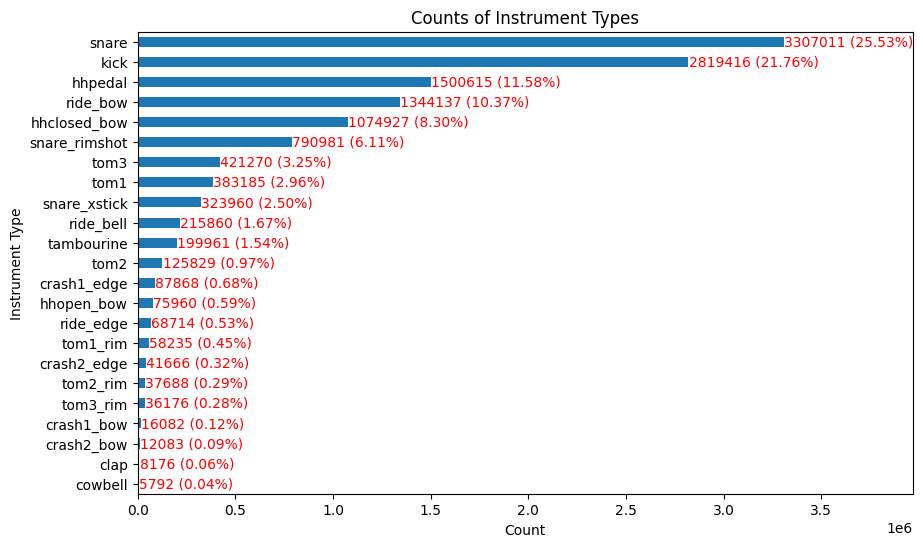

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
instrument_type_counts.plot(kind='barh', ax=ax)
for i, v in enumerate(instrument_type_counts):
    label = f'{v} ({v/sum(instrument_type_counts)*100:.2f}%)'
    ax.text(v+1000, i, label, color='red', va='center')
ax.invert_yaxis()
ax.set_xlim([0, max(instrument_type_counts) * 1.2])
plt.ylabel('Instrument Type')
plt.xlabel('Count')
plt.title('Counts of Instrument Types')
plt.show()

Based on the frequency distribution chart of the classes in the drum dataset, we can assert that the majority of classes consist of bass and snare drums, followed by hats & rides, toms, and then cymbals. This is logical because bass and snare drums are essential for creating rhythm and are used more frequently than other types of drums. On the flip side, crash cymbals are often used to transition between sections and are not used as frequently for rhythm. Therefore, there is an inherent disparity in the frequency of usage among the different drum types, solely based on the natural way drums are played.

As it stands, we have created an ***insanely*** unbalanced dataset. The crash cymbals are in the thousands, while the snares are 50x as prevalent. We need a way to deal with this natural class imbalance, as it will hinder the model's ability to identify the minority classes with a bias towards the majority classes.

There are several ways to combat this class imbalance:

1. **Data augmentation:** This involves creating new examples of the minority class by applying various transformations to the existing examples. For example, we can use pitch shifting, time stretching, or other audio effects to create new versions of the crash cymbal sounds. This can help increase the amount of data available for the minority class and improve the model's ability to recognize it.

2. **Upsampling:** Upsampling involves duplicating examples of the minority class to increase their representation in the dataset. This can be done randomly, or using more sophisticated techniques like SMOTE (Synthetic Minority Over-sampling Technique), which generates new synthetic examples of the minority class by interpolating between existing examples.

3. **Downsampling:** Downsampling involves reducing the number of examples of the majority class to match the number of examples of the minority class. This can be done randomly, or using more sophisticated techniques like Tomek links, which remove examples from the majority class that are close to examples from the minority class.

4. **Weighted loss functions:** We can use a weighted loss function that gives more importance to the minority class during training. This can help the model learn to focus on the minority class and improve its ability to recognize it.

5. **Ensemble models:** An ensemble model combines multiple models to improve performance. We can train several models on different subsets of the data, with each subset having an equal number of examples from each class. The models can then be combined to create a final prediction.

6. **Genre variation:** Another thing we can do is introduce more varied genres of play. Punk-rock music often utilizes the crash cymbal for rhythm purposes, and as such, can be used to introduce thousands of crash cymbals into the dataset. As it stands, the database seems heavily biased towards rock, whereas my goal is to create a tool for starter drummers, where punk-rock is a cornerstone of learning.